In [ ]:
# Connect to the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 14.9 MB/s 
     |████████████████████████████████| 1.6 MB 65.3 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import numpy as np
import datetime
import pathlib
import random
import time
import sys
import os 
sys.path.append("/content/drive/MyDrive/Github/face-comic-recognizer/scr")
from constants import IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED
from data_util import *
from my_model import VGGModel
from tensorflow.python.client import device_lib

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def make_datermenistic(seed=SEED):
    """
    Ensures reproducibility of the results.
    Not guaranteed with GPU.
    """
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

# (0) Data loading

In [ ]:
# Upload kaggle.json
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Kaggle"
# The dataset will be stored in Google Colab, not in Google Drive!
!pip install --upgrade kaggle
!kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
!unzip \*.zip  
%rm *.zip
%rm -rf face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5503.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5504.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5505.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5506.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5507.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5508.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5509.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/551.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5510.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/5511.jpg  
  inflating: face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/face

In [ ]:
data_dir = pathlib.Path("/content/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela")
image_count = len(list(data_dir.glob('*/*.jpg')))

# (1) Data extraction

In [ ]:
train_ds_paths, val_ds_paths, test_ds_paths = train_val_test_split(
    get_file_paths(folder_path=data_dir), 
    image_count,
    data_dir)

The train set: tf.Tensor(16000, shape=(), dtype=int64)
The validation set: tf.Tensor(2000, shape=(), dtype=int64)
The test set: tf.Tensor(2000, shape=(), dtype=int64)


In [ ]:
# Create the color subsets from the file paths
train_ds = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
val_ds = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))
test_ds = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, True), num_parallel_calls=AUTOTUNE))

In [ ]:
# Create the grayscale subsets from the file paths
train_ds_gs = prepare_for_training(train_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
val_ds_gs = prepare_for_training(val_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))
test_ds_gs = prepare_for_training(test_ds_paths.map(lambda x: process_path(x, data_dir, False), num_parallel_calls=AUTOTUNE))

In [ ]:
show_batch_examples(train_ds, data_dir)

In [ ]:
show_batch_examples(val_ds, data_dir)

# (2) Training, hyperparameters tuning, testing

## (*) Setup

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [ ]:
def plot_loss_accuracy(model, 
                       epoch,
                       size=16):

    train_loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    val_acc = model.history.history['val_accuracy']
    xax = range(epoch)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    ax[0].set_xlabel('Epochs', fontsize=size)
    ax[1].set_xlabel('Epochs', fontsize=size)
    ax[0].set_ylabel('Loss', fontsize=size)
    ax[1].set_ylabel('Accuracy', fontsize=size)

    ax[0].tick_params(axis='both', which='major', labelsize=size)
    ax[1].tick_params(axis='both', which='major', labelsize=size)

    ax[0].plot(xax, train_loss, label="Train")
    ax[0].plot(xax, val_loss, label="Validation")
    ax[1].plot(xax, train_acc, label="Train")
    ax[1].plot(xax, val_acc, label="Validation")

    #ax[0].set_title('Loss')
    #ax[1].set_title('Accuracy')
    ax[0].legend(prop={'size': size - 4 })
    ax[1].legend(prop={'size': size - 4 })

    fig.tight_layout()


In [ ]:
# Define the checkpoint directory to store the checkpoints.
def checkpoint_save():
    checkpoint_dir = '/content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints'
    checkpoint_dir_full = os.path.join(checkpoint_dir,  datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    %mkdir {checkpoint_dir_full}
    checkpoint_prefix = os.path.join(checkpoint_dir_full, "ckpt_{epoch}")
    print("Checkpoints: " + checkpoint_prefix)
    print("-" * 15)
    return checkpoint_prefix

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy()

Num GPUs Available:  1


### (2.1) Baseline model

In [ ]:
EPOCHS = 12

In [ ]:
LEARNING_RATE = 1e-3
DROPOUT_RATE = 2e-1

In [ ]:
def vgg_compile_distributed(func):
    def optimize_performance(lr, drop_rate):
        print("Don't forget to switch to GPU :)")
        print("-" * 15)
        with strategy.scope():
            f = func(lr, drop_rate)
        return f
    return optimize_performance

In [ ]:
@vgg_compile_distributed
def vgg_compile(lr, drop_rate):
    make_datermenistic()
    model = VGGModel(2, drop_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                 metrics=['accuracy'])
    return model

In [ ]:
def train_test(lr=LEARNING_RATE, 
               drop_rate=DROPOUT_RATE, 
               ep=EPOCHS, 
               bs=BATCH_SIZE,
               save=True):
    
    path = '/content/drive/MyDrive/Github/face-comic-recognizer/models/saved_models'
    full_path = os.path.join(path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    %mkdir {full_path}

    model = vgg_compile(lr, drop_rate)
    
    callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save(),
                                       save_weights_only=True)]
    model.fit(train_ds_gs, 
              validation_data=val_ds_gs,
              epochs=ep,
              batch_size=bs,
              callbacks=callbacks)
    
    if save:
        model.save(full_path, save_format='tf')

    return model


In [ ]:
baseline_model = train_test()

Don't forget to switch to GPU :)
---------------
Checkpoints: /content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints/20221210-172448/ckpt_{epoch}
---------------
Epoch 1/12
500/500 [==============================] - 72s 135ms/step - loss: 0.2252 - accuracy: 0.9839 - val_loss: 10.3879 - val_accuracy: 0.4910
Epoch 2/12
500/500 [==============================] - 66s 131ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 4.8834e-04 - val_accuracy: 0.9995
Epoch 3/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 0.8504 - val_accuracy: 0.7770
Epoch 4/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0116 - val_accuracy: 0.9960
Epoch 5/12
500/500 [==============================] - 65s 131ms/step - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0547 - val_accuracy: 0.9870
Epoch 6/12
500/500 [==============================] - 65s 130ms/step - loss: 0.0109 - accura

---------------
Time of execution: 795.457
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14229315486976324124
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5256354563147095092
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


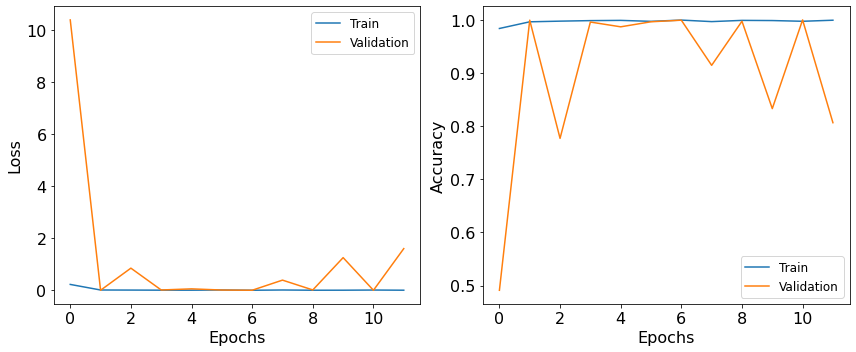

In [ ]:
plot_loss_accuracy(baseline_model)

In [ ]:
baseline_model.evaluate(test_ds_gs) 

63/63 [==============================] - 3s 41ms/step - loss: 1.5699 - accuracy: 0.8130


[1.5699176788330078, 0.8130000233650208]

## (2.2) Hyperparameters optimization

In [ ]:
def hp_model(hp):
  
  hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  hp_drop_rate = hp.Choice('drop_rate',  values=[1e-1, 2e-1, 3e-1, 4e-1])

  model = vgg_compile(lr=hp_lr, drop_rate=hp_drop_rate)

  return model

In [ ]:
tuner = kt.BayesianOptimization(hp_model,
                     objective='val_accuracy',
                     max_trials=6,
                     seed=SEED,
)

Don't forget to switch to GPU :)
---------------


In [ ]:
tuner.search(train_ds_gs, 
             validation_data=val_ds_gs, 
             epochs=8, 
             #validation_split=0.2, 
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                         patience=4)] 
             )

Trial 6 Complete [00h 09m 28s]
val_accuracy: 0.9990000128746033

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 49m 03s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
learning rate:{best_hps.get('learning_rate')} 
dropout: {best_hps.get('drop_rate')}
""")



learning rate:0.0001 
dropout: 0.1



## (2.3) Optimized model

In [ ]:
EPOCHS = 12
LEARNING_RATE = 1e-4
DROPOUT_RATE = 1e-1

In [ ]:
optimized_model = train_test(lr=LEARNING_RATE, drop_rate=DROPOUT_RATE, ep=EPOCHS)

Don't forget to switch to GPU :)
---------------
Checkpoints: /content/drive/MyDrive/Github/face-comic-recognizer/models/checkpoints/20221210-204520/ckpt_{epoch}
---------------
Epoch 1/12
500/500 [==============================] - 75s 144ms/step - loss: 0.0351 - accuracy: 0.9895 - val_loss: 4.2695 - val_accuracy: 0.4955
Epoch 2/12
500/500 [==============================] - 70s 141ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0102 - val_accuracy: 0.9965
Epoch 3/12
500/500 [==============================] - 70s 140ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.5160 - val_accuracy: 0.8885
Epoch 4/12
500/500 [==============================] - 70s 140ms/step - loss: 3.1069e-04 - accuracy: 0.9999 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 5/12
500/500 [==============================] - 70s 141ms/step - loss: 8.7747e-05 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/12
500/500 [==============================] - 70s 140ms/step - loss: 5.5492e-06 -

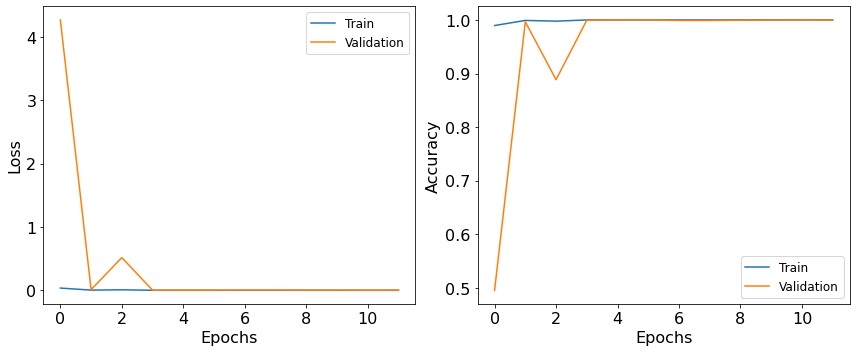

In [ ]:
plot_loss_accuracy(optimized_model, epoch=EPOCHS)

In [ ]:
optimized_model.evaluate(test_ds_gs)

63/63 [==============================] - 9s 134ms/step - loss: 0.0069 - accuracy: 0.9985


[0.006859000772237778, 0.9984999895095825]